# Packages

In [115]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pySODM.models.base import ODEModel
from covid19_DTM.data.utils import construct_initN
from covid19_DTM.models.TDPF import ramp_fun
from covid19_DTM.models.TDPF import make_seasonality_function
from covid19_DTM.data.sciensano import get_sciensano_COVID19_data
import csv
from csv import DictReader
from functools import lru_cache
from matplotlib import font_manager

# Data

In [116]:
# Postponed healthcare data
abs_dir = os.getcwd()
rel_dir = '../../data/PHM/interim/UZG/'
file_name = '2020_2021_normalized.csv'
types_dict = {'APR_MDC_key': str}
# mean data
hospitalizations_normalized = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True)['mean']
hospitalizations_normalized = hospitalizations_normalized.reorder_levels(['date','APR_MDC_key'])
hospitalizations_normalized=hospitalizations_normalized.sort_index()
MDC_keys = hospitalizations_normalized.index.get_level_values('APR_MDC_key').unique().values

# lower and upper quantiles
hospitalizations_normalized_quantiles = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict,parse_dates=True).loc[(slice(None), slice(None)), ('q0.025','q0.975')]
hospitalizations_normalized_quantiles = hospitalizations_normalized_quantiles.reorder_levels(['date','APR_MDC_key'])
hospitalizations_normalized_quantiles=hospitalizations_normalized_quantiles.sort_index()

# COVID-19 data
covid_data, _ , _ , _ = get_sciensano_COVID19_data(update=False)
new_index = pd.MultiIndex.from_product([pd.to_datetime(hospitalizations_normalized.index.get_level_values('date').unique()),covid_data.index.get_level_values('NIS').unique()])
covid_data = covid_data.reindex(new_index,fill_value=0)
df_covid_H_in = covid_data['H_in'].loc[:,40000]
df_covid_H_tot = covid_data['H_tot'].loc[:,40000]
df_covid_dH = df_covid_H_tot.diff().fillna(0)

MDC_dict={}
file_name = 'MDC_dict.csv'
with open(os.path.join(abs_dir,rel_dir,file_name), mode='r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        MDC_dict.update({row[0]:row[1]})

# Models and functions

In [117]:
class constrained_PI(ODEModel):
    """
    Test constrainted PI model
    """
    
    state_names = ['H','E']
    parameter_names = ['covid_H','covid_dH']
    parameter_stratified_names = ['Kp', 'Ki', 'alpha','gamma', 'covid_capacity']
    dimension_names = ['MDC']
    
    @staticmethod
    def integrate(t, H, E, covid_H, covid_dH, Kp, Ki, alpha, gamma, covid_capacity):

        epsilon = 1-H
        dE = epsilon - gamma*E
        u = np.where(covid_H <= covid_capacity, Kp * np.where(E<=0,epsilon,0) + Ki * np.where(E>0,E,0), 0)
        dH = -alpha*covid_dH + u

        return dH, dE 

In [118]:
class PI(ODEModel):
    """
    Test PI model
    """
    
    state_names = ['H','E']
    parameter_names = ['covid_H']
    parameter_stratified_names = ['Kp', 'Ki', 'alpha', 'gamma']
    dimension_names = ['MDC']
    
    @staticmethod
    def integrate(t, H, E, covid_H, Kp, Ki, alpha, gamma):

        epsilon = 1-H
        dE = epsilon - gamma*E
        u = Kp*epsilon + Ki*E
        dH = -alpha*covid_H + u

        return dH, dE 

In [119]:
class get_covid_H():

    def __init__(self, data):
        self.data = data

    def H_wrapper_func(self, t, states, param):
        return self.__call__(t)

    @lru_cache()
    def __call__(self, t):
        t = pd.to_datetime(t).round(freq='D')
        if t > pd.to_datetime('2020-07-01'):
            covid_H = 0
        else:
            try:
                covid_H = self.data.loc[t]
            except:
                covid_H = 0
        return covid_H  

In [120]:
class get_covid_dH():

    def __init__(self, data):
        self.data = data

    def dH_wrapper_func(self, t, states, param):
        return self.__call__(t)

    @lru_cache
    def __call__(self, t):
        t = pd.to_datetime(t).round(freq='D')
        if t > pd.to_datetime('2020-07-01'):
            covid_dH = 0
        else:
            try:
                covid_dH = self.data.loc[t]
            except:
                covid_dH = 0

        return covid_dH

In [121]:
def hypothetical_covid_peak_getH(t, states, param,start_peak,end_peak,peak_amplitude):
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    if t <= start_peak:
        covid_H = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    else:
        covid_H=0

    return covid_H

In [122]:
def hypothetical_covid_peak_getdH(t, states, param,start_peak,end_peak,peak_amplitude):
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    if t <= start_peak:
        covid_dH = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_dH = peak_amplitude/(l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_dH = -peak_amplitude/(l/2)
    else:
        covid_dH=0

    return covid_dH

In [198]:
def init_model(model_class, MDC=['05',],hypothetical=False):
    n = len(MDC)
    # params
    if model_class.__name__ == "PI":
        # PI
        alpha = (0.00005*np.ones(n))
        gamma = (0.05*np.ones(n))

        Kp = (0.01*np.ones(n))
        Ki = (0.005*np.ones(n))
    else:
        # constrained PI
        alpha = (0.001*np.ones(n))
        gamma = (0.01*np.ones(n))

        Kp = (0.05*np.ones(n))
        Ki = (0.0005*np.ones(n))

    # initial values covid params
    covid_H = 0
    covid_dH = 0
    covid_capacity = (300*np.ones(n))

    global_params_dict={'alpha':alpha,
            'gamma':gamma,
            'Kp':Kp,
            'Ki':Ki,
            'covid_H':covid_H,
            'covid_dH':covid_dH,
            'covid_capacity':covid_capacity
            }

    #time dependent functions
    if hypothetical:
        H_function = hypothetical_covid_peak_getH
        dH_function = hypothetical_covid_peak_getdH
    else:
        H_function = get_covid_H(df_covid_H_tot).H_wrapper_func
        dH_function = get_covid_dH(df_covid_dH).dH_wrapper_func
    global_time_dependent_parameters={'covid_H': H_function,'covid_dH':dH_function}

    # Initialize model
    init_states = {'H':np.ones(n),'E':np.zeros(n)}
    coordinates={'MDC': MDC}

    # param and time dependent param dictionary specific for model class
    params_dict = {}
    time_dependent_parameters = {}

    for param in model_class.parameter_names + model_class.parameter_stratified_names:
        params_dict.update({param:global_params_dict[param]})
        if param in list(global_time_dependent_parameters.keys()):
            time_dependent_parameters.update({param:global_time_dependent_parameters[param]})
    if hypothetical:
        params_dict.update({'start_peak':pd.to_datetime('2020-02-01'),'end_peak':pd.to_datetime('2020-05-01'),'peak_amplitude':15})
    # Initialize model
    model = model_class(init_states,params_dict,coordinates,time_dependent_parameters=time_dependent_parameters)
    return model

# Test model

In [138]:
start_sim = pd.to_datetime('2020-01-01')
end_sim = pd.to_datetime('2020-10-01')
sim_time = pd.date_range(start_sim,end_sim)

plot_start_date = pd.to_datetime('2020-01-01')
plot_end_date = pd.to_datetime('2020-10-01')
plot_time = pd.date_range(plot_start_date,plot_end_date)

start_peak = pd.to_datetime('2020-02-01')
end_peak = pd.to_datetime('2020-04-01')
peak_amplitude = 20

In [187]:
model = init_model(constrained_PI)
out = model.sim([start_sim,end_sim])

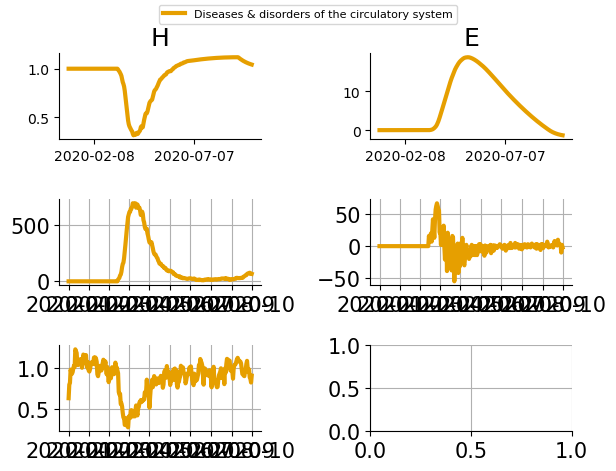

In [188]:
fig, axs = plt.subplots(3,2)
axs = axs.reshape(-1)

idx=0
for state in model.state_names:
    for disease in out.MDC.values:
        out_plot = out.sel(MDC=disease)[state]
        axs[idx].plot(sim_time,out_plot, label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    idx+=1

axs[-4].plot(df_covid_H_tot[sim_time])
axs[-3].plot(df_covid_dH[sim_time])
axs[-2].plot(sim_time,hospitalizations_normalized.loc[(sim_time,'05')])

plt.tight_layout()
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

# Parameter influences

In [176]:
abs_dir = os.getcwd()
result_folder = '../../results/PHM/analysis/PI_models/parameter_influences'
result_path = os.path.join(abs_dir,'../../results/calibrations/Postponed_Healthcare/')

if not os.path.exists(result_path):
    os.makedirs(result_path)

label_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=10)
legend_font = font_manager.FontProperties(family='CMU Sans Serif',
                                style='normal', 
                                size=8)

## constrained PI

In [206]:
MDC = ['05',]

gamma_choices = [0,0.01,0.05]

alpha_choices = [0.0005,0.001,0.0015]

Kp_choices = [0.01,0.05,0.1]

KI_choices = [0.0001,0.0005,0.001]

covid_capacity_choices = [50,300,1000]

parameters = {'gamma':gamma_choices,'alpha':alpha_choices,'Kp':Kp_choices,'Ki':KI_choices,'covid_capacity':covid_capacity_choices}

gamma
alpha
Kp
Ki
covid_capacity


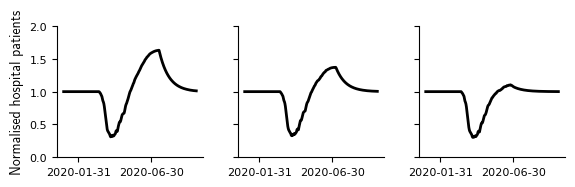

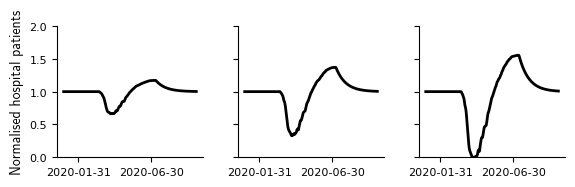

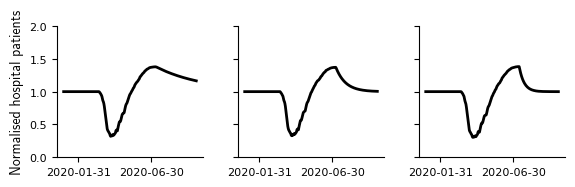

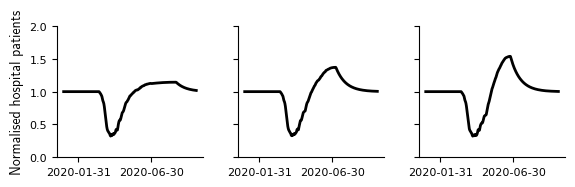

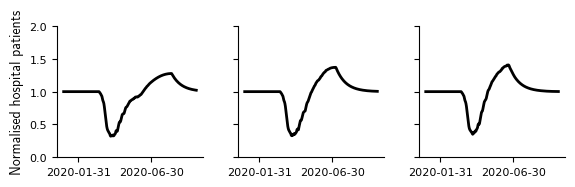

In [207]:
for parameter_name,parameter_choices in parameters.items():
    fig, axs = plt.subplots(1,3,figsize=(6,2),sharey=True,sharex=True)
    print(parameter_name)
    model = init_model(constrained_PI)
    for i,parameter_value in enumerate(parameter_choices):
        model.parameters.update({parameter_name:parameter_value})
        out = model.sim([start_sim,end_sim])
        for disease in MDC:
            out_plot = out.sel(MDC=disease,date=plot_time)['H']
            axs[i].plot(plot_time,out_plot,color='black',linewidth=2)
            axs[i].set_ylim([0,2])
            #axs[i].set_title(f'{string.ascii_lowercase[i]})',font=label_font)
            axs[i].xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='5M'))
            axs[i].tick_params(axis='both', which='major', labelsize=8)
            axs[i].grid(False)
    axs[0].set_ylabel('Normalised hospital patients',font=label_font)
    fig.tight_layout()
    fig.savefig(os.path.join(result_folder,f'constrained_PI_{parameter_name}'),dpi=600,bbox_inches='tight')

## PI

In [177]:
MDC = ['05',]

alpha_choices = [0.00001,0.00005,0.0001]

gamma_choices = [0.02,0.05,0.1]

KI_choices = [0.001,0.005,0.01]

Kp_choices = [0,0.01,0.05]

parameters = {'alpha':alpha_choices,'gamma':gamma_choices,'Ki':KI_choices,'Kp':Kp_choices}

alpha
gamma
Ki
Kp


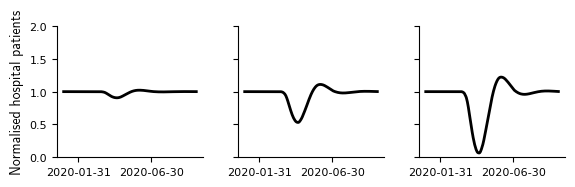

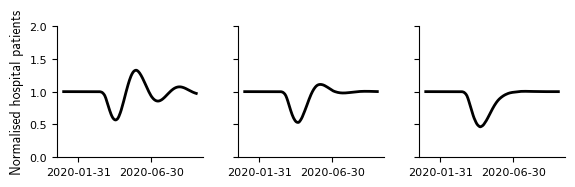

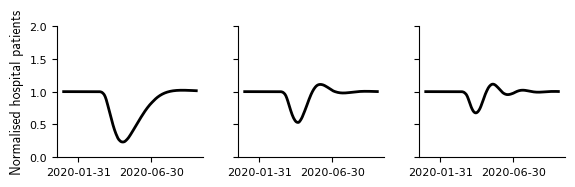

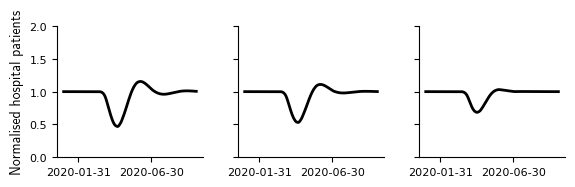

In [178]:
for parameter_name,parameter_choices in parameters.items():
    fig, axs = plt.subplots(1,3,figsize=(6,2),sharey=True,sharex=True)
    print(parameter_name)
    model = init_model(PI)
    for i,parameter_value in enumerate(parameter_choices):
        model.parameters.update({parameter_name:parameter_value})
        out = model.sim([start_sim,end_sim])
        for disease in MDC:
            out_plot = out.sel(MDC=disease,date=plot_time)['H']
            axs[i].plot(plot_time,out_plot,color='black',linewidth=2)
            axs[i].set_ylim([0,2])
            #axs[i].set_title(f'{string.ascii_lowercase[i]})',font=label_font)
            axs[i].xaxis.set_ticks(pd.date_range(plot_start_date,plot_end_date,freq='5M'))
            axs[i].tick_params(axis='both', which='major', labelsize=8)
            axs[i].grid(False)
    axs[0].set_ylabel('Normalised hospital patients',font=label_font)
    fig.tight_layout()
    fig.savefig(os.path.join(result_folder,f'PI_{parameter_name}'),dpi=600,bbox_inches='tight')